In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from multiprocessing import Pool, shared_memory

In [2]:
from scipy.stats import erlang
import math
def create_exp_dist(lamb):
    def exp_dist(x):
        return lamb*np.exp(-lamb*x)
    return exp_dist

def create_Erlang_dist(lamb, k):
    def Erlang_dist(x):
        return erlang.pdf(x, k, scale=1/lamb)
#         ret = np.exp(-lamb*x)*lamb
#         for i in range(1, k):
#             ret = ret*(x*lamb)/i
#         return ret#np.exp(-lamb*x)*((x*lamb)**k)/x#(x*math.factorial(k-1))
    return Erlang_dist
    
def alpha(c, dist_func=None):
    assert dist_func != None
    return integrate.quad(lambda x: (1-(x/c))*dist_func(x),
                          0, 
                          c)[0]

In [3]:
ns = np.array([4, 8, 16, 32, 64, 
               128, 256, 512, 1024, 
               2048, 4096])#, 8192])
trials = np.array([10000,10000,10000,10000,10000,
                   1000,1000,1000,1000,1000, 
                   500, 500])
c = 1#10
lambs = np.array([ c, c*50, 100*c])

dists = np.array([[create_Erlang_dist(np.sqrt(n-1)*lamb, n-1)
                  for n in ns]
                  for lamb in lambs ])
alphas = np.array([[alpha(c, dist) 
                    for dist in dists[i, :]]
                    for i in range(dists.shape[0])
                  ])
alphas_n = np.array([[alpha**n
                      for alpha, n in zip(alphas[i, :], ns)]
                      for i in range(alphas.shape[0])
                  ])

In [4]:
def sample_matrix(n, p_diag, p_off_diag):
    """Sample a random matrix
       n:          the size of the matrix (n,n).
       p_diag:     The function that samples n elements for diagonal terms
                   it must have a signiture like p_diag(n,S).
       p_off_diag: The function that samples (n,n) elements for off-diagonal terms
                   it must have a signiture like p_off_diag(n,S).
    """
    
    # Create an n by n matrices, sampled from 'p_off_diag' distribution
    m = p_off_diag(n)
    # Fill the diagonal terms by sampling from 'p_diag' distribution
    m[np.diag_indices(n)] = p_diag(n)    
    return m

def sample_matrix2(n, S, p_diag, p_off_diag):
    """Sample a random matrix
       n:          the size of the matrix (n,n).
       S:          the average number of non-zero off-diagonal elements.
       p_diag:     The function that samples n elements for diagonal terms
                   it must have a signiture like p_diag(n,S).
       p_off_diag: The function that samples (n,n) elements for off-diagonal terms
                   it must have a signiture like p_off_diag(n,S).
    """
    
    # A binomial distribution with p=S/n always have the mean equals S
    # By setting N=1, we get 0 or one for each trials, which on average
    # S times is 1
    # So, the following create an n by n matrices of zeros and one such that
    # the expectation of getting non-zero element is S
    if S > n-1:
        p = 1.0
    else:
        p = S/(n-1)
    off_diag_indices = np.random.binomial(1, p, (n, n))
    # Since we sample the  diagonal terms differently, we fill their indices by one
    off_diag_indices[np.diag_indices(n)] = 0
    #print(off_diag_indices)
    
    # Create an n by n matrices, sampled from 'p_off_diag' distribution
    m = p_off_diag(n, S)
    #print(m)
    # Remove all the terms that is supposed to be zero (no regulation)
    # including the diagonals
    m = m*off_diag_indices
    #print(m)
    # Fill the diagonal terms by sampling from 'p_diag' distribution
    m[np.diag_indices(n)] = p_diag(n, S)
    #print(m)
    return m

def matrix_intervals(m, axis=1):
    """Turn a matrix to row(column)-wise intervals
    
       args:
           m: (n,n) numpy array.
           axis:  use one for row-wise and zero for
                  column-wise intervals.
    """
    # Get the diagonal terms
    ds = np.diag(m)
    # Sum of absolute value of off-diagonal elements
    rs = np.sum(np.abs(m - np.diag(ds)), axis = axis)
    # create intrvals around the diagonal terms
    return np.array([ (d-r, d+r) for d, r in zip(ds, rs) ])

def alg1(m, axis=1):
    """Specifies the stabaility property of the matrix.
    
       args:
           m: (n,n) numpy array.
           axis:  use one for row-wise and zero for
                  column-wise intervals.
       return:
               0 - super-stable
               1 - inconclusive
               2 - unstable
    
    """
    n = m.shape[0]
    intervals = matrix_intervals(m,axis)
    us = np.array([u for _,u in intervals])
    ls = np.array([l for l,_ in intervals])
    u_max_index = np.argmax(us)
    u_max = us[u_max_index]    
    if u_max < 0:# Super-stable
        return 0
    
    l_i = ls[u_max_index] 
    if l_i < 0:# Inconclusive
        return 1
    indices = [i for i in range(0, n) if i != u_max_index]
    for j in indices:
        l_j, u_j = ls[j], us[j]
        if l_i < u_j:
            if l_j < l_i:
                l_i = l_j
            if l_i < 0:# Inconclusive
                return 1
    return 2# unstable            

def alg2(m, axis=1):
    """Specifies if the stabaility property can be tightened.
    
       args:
           m: (n,n) numpy array.
           axis:  use one for row-wise and zero for
                  column-wise intervals.
       return:
               0 - super-stable
               1 - inconclusive
               2 - unstable
    
    """
    n = m.shape[0]
    # Get the diagonal terms
    ds = np.diag(m)
    # Sum of absolute value of off-diagonal elements
    rs = np.sum(np.abs(m - np.diag(ds)), axis = axis)
    a_max_index = np.argmax(ds)
    a_ii = ds[a_max_index]
    r_i = rs[a_max_index]
    indices = [i for i in range(0, n) if i != a_max_index]
    if a_ii > 0:        
        for j in indices:
            r_j = rs[j]
            a_jj = m[j,j]
            if axis == 0:
                a_ji = m[j, a_max_index]
            else:
                a_ji = m[a_max_index, j]
            c_0 = r_i
            c_1 = a_jj-a_ii+r_j-np.abs(a_ji)
            c_2 = np.abs(a_ji)                        
            d_max = np.real(np.max(np.roots([c_2, c_1, c_0])))
            if d_max <= r_i/a_ii:
                return 1 # Inconclusive
            if c_1 >= 0:                
                return 1 # Inconclusive
            if c_1*c_1 <= 4*np.abs(a_ji*r_i):                
                return 1 # Inconclusive
        return 2 # Unstable
    else:
        #r_j = rs[j]
        #a_jj = m[j,j]
        #a_ji = m[j, a_max_index]
        #if r_i/np.abs(a_ii) >= np.min([ (np.abs(a_jj)-r_j)/np.abs(a_ji)  for j in indices]):
        # select r_i, a_jj and a_ji
        if axis == 0:
            parts = [(rs[j], m[j,j], m[j, a_max_index]) for j in indices]
        else:
            parts = [(rs[j], m[j,j], m[a_max_index, j]) for j in indices]
        values = [(np.abs(a_jj)-r_j)/np.abs(a_ji)  for (r_j, a_jj, a_ji) in parts]
        if r_i/np.abs(a_ii) >= np.min(values):
            return 1 # Inconclusive
        return 0 # Super-stable

def alg(m):
    ret = alg1(m, axis = 0)
    if ret != 1:
        return ret
    ret = alg1(m, axis = 1)
    if ret != 1:
        return ret
    ret = alg2(m, axis = 0)
    if ret != 1:
        return ret
    return alg2(m, axis = 1)

In [5]:
def p_diag_uniform(low):
    def uniform(n):
        return np.random.uniform(low, 0, n)    
    return uniform

def p_off_diag_exp(lamb, scaling_factor=1.):
    def exp(n):        
        #p = np.random.uniform(0, 1)        
        p = .5
        return (
            np.random.exponential(1/lamb, (n,n))*
            np.where(np.random.binomial(1, p, (n, n)) == 0, -1, 1)
            #np.where(np.random.randint(0,2, (n,n)) ==0, -1, 1)
        )/scaling_factor
    return exp

def is_unstable(m):
    """Find the linear stability of a matrix"""
    return np.any(np.real(sp.linalg.eigvals(m)) > 0)

In [40]:
import math
def psn3(c, lamb, k):
        
    def second_int(r):
        return ((np.pi/2) 
                - (r/c)*np.sqrt(1- (c/r)**2)
                + (r/(3*c))*np.power(1- (c/r)**2, 3/2)
                - np.arcsin(c/r))
    def partial_E():
        def func(r):
            ret = second_int(r) * lamb  * np.exp(-lamb*r)
            for i in range(1, k):
                ret = ret*lamb*r/i
            return ret
            #return second_int(r) * (lamb**k) * (r**(k-1)) * np.exp(-lamb*r)/math.factorial(k-1)
        return integrate.quad(func,
                              c, np.inf)[0]
    return (k/(3*lamb*np.pi*c)) + (1/(np.pi))*partial_E()

In [6]:
repeats = 10
def proc_stability2(args):
    n, lamb, c, trials, repeat_id = args
    super_stable_count = 0
    stable_count = 0
    for i in range(trials):
        # All the of-diagonal elements are non-zero
        # Also, the off-diagonal rate is scaled by sqrt(n)
        m = sample_matrix(n, 
                          p_diag_uniform(-c), 
                          p_off_diag_exp(lamb*np.sqrt(n-1)))
        region1 = alg1(m, axis=0)
        #region2 = alg1(m, axis=1)
        if region1 == 0:# or region2 == 0:
            super_stable_count += 1
#         if region == 1:
#             if not is_unstable(m):
#                 stable_count += 1
        
    
    
    return (repeat_id, super_stable_count/trials)#, stable_count/trials)

params3 = [ (n, lamb, c, t, repeat_id) 
           for (n,t) in zip(ns, trials) for lamb in lambs for repeat_id in range(repeats)]
with Pool(55) as pool:
    res3 = pool.map(proc_stability2, params3)

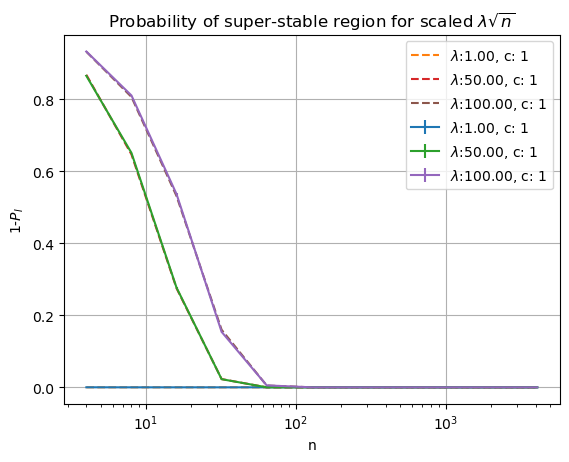

In [7]:
stats_super_stable = np.zeros((ns.shape[0], lambs.shape[0], repeats))
mean_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
std_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
for j,n in enumerate(ns):
    for k,lamb in enumerate(lambs):
        for t in range(repeats):
            index = j*lambs.shape[0]*repeats + k*repeats + t
            stats_super_stable[j, k, t ] =   res3[index][1]
            
mean_super_stable = np.mean(stats_super_stable, axis=2)
std_super_stable = np.std(stats_super_stable, axis=2)

for k,lamb in enumerate(lambs):
    plt.errorbar(ns, mean_super_stable[:, k],
                 yerr=std_super_stable[:, k],
                 label=r"$\lambda$:" f"{lamb:2.2f}, c:{c:2.0f}")
    plt.plot(ns,
             alphas_n[k, :], '--',
             label=r"$\lambda$:" f"{lamb:2.2f}, c:{c:2.0f}")

plt.xlabel("n");plt.ylabel(r"1-$P_I$");plt.title(r"Probability of super-stable region for scaled $\lambda \sqrt{n}$")    
plt.legend();plt.grid();plt.xscale('log');plt.show()



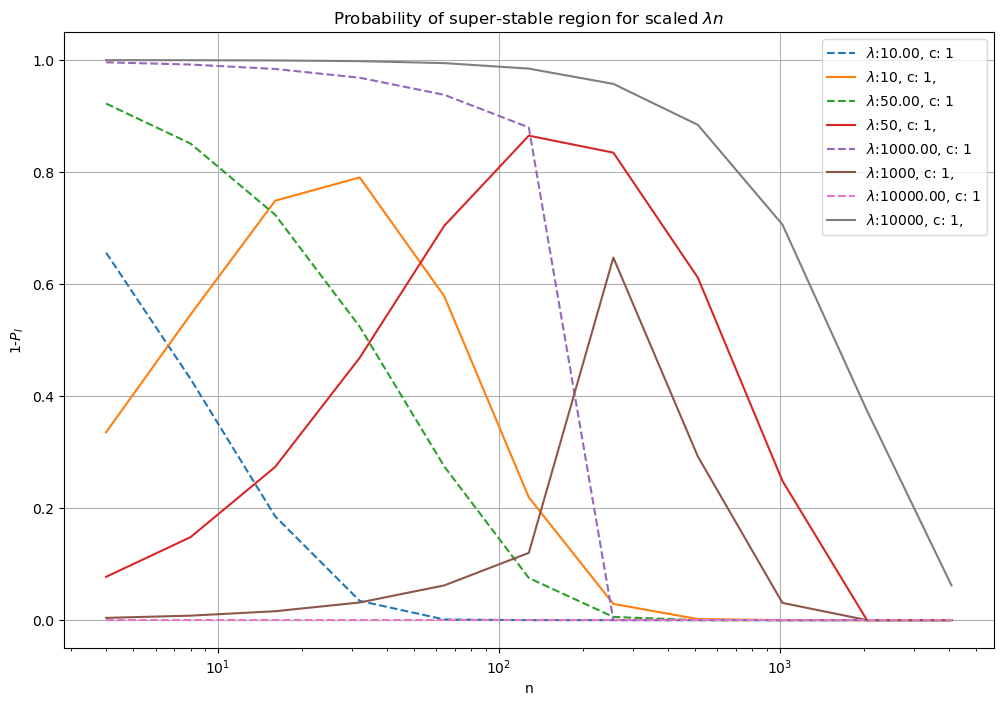

In [51]:
ns2 = np.array([4, 8, 16, 32, 64, 
               128, 256, 512, 1024, 
               2048, 4096])#, 8192])
c2 = 1#10
lambs2 = np.array([ c2*10, c2*50,  1000*c2, 10000*c2])

dists2 = np.array([[create_Erlang_dist((n-1)*lamb, n-1)
                     #create_Erlang_dist(lamb, n-1)
                  for n in ns2]
                  for lamb in lambs2 ])
alphas2 = np.array([[alpha(c2, dist) 
                    for dist in dists2[i, :]]
                    for i in range(dists2.shape[0])
                  ])
alphas_n2 = np.array([[alpha**n
                      for alpha, n in zip(alphas2[i, :], ns2)]
                      for i in range(alphas2.shape[0])
                  ])

gamma = 0.0005
gammas_2 = np.array([[ psn3(c, lamb*np.sqrt(n), n) for n in ns2] for lamb in lambs2])

plt.figure(figsize=(12,8))
for k,lamb in enumerate(lambs2):
    plt.plot(ns2,
             alphas_n2[k, :], '--',
             label=r"$\lambda$:" f"{lamb:2.2f}, c:{c2:2.0f}")
    
#     plt.plot(ns,
#              (1 - gamma*(1-alphas2[k, :]))**ns2 - alphas2[k, :]**ns2, '-',
#              label=r"$\lambda$:" f"{lamb:2.0f}, c:{c2:2.0f}, " r"$\gamma:$" f"{gamma}")
    
    plt.plot(ns,
             (1 - gammas_2[k, :]*(1-alphas2[k, :]))**ns2 - alphas2[k, :]**ns2, '-',
             label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}, " )


plt.xlabel("n");plt.ylabel(r"1-$P_I$");plt.title(r"Probability of super-stable region for scaled $\lambda n$")    
plt.legend();plt.grid();plt.xscale('log');plt.show()


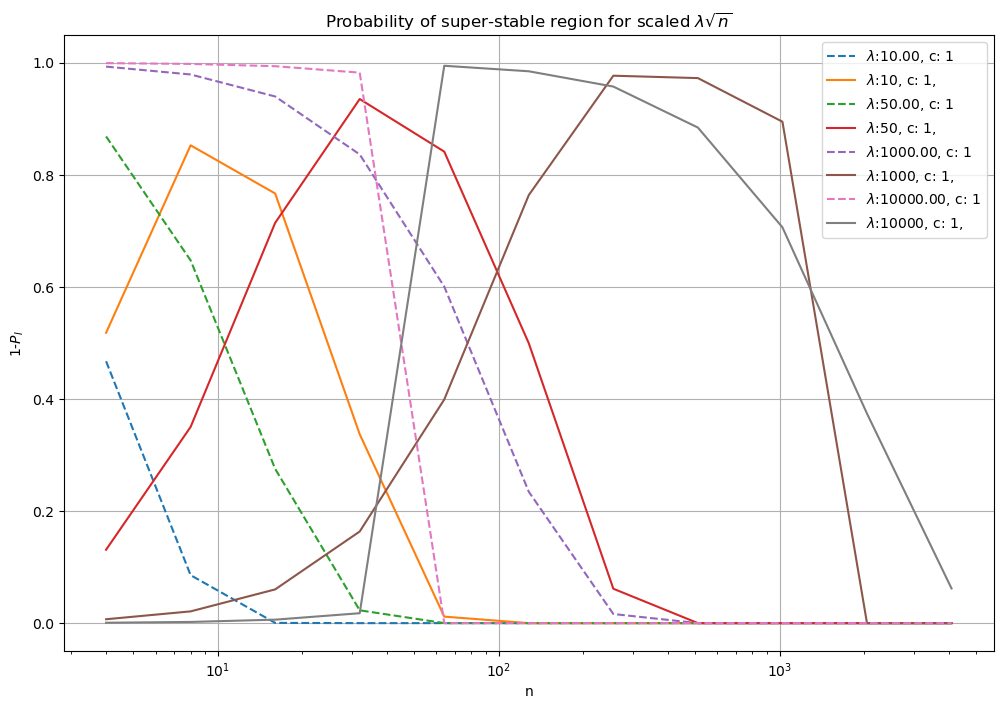

In [49]:
ns2 = np.array([4, 8, 16, 32, 64, 
               128, 256, 512, 1024, 
               2048, 4096])#, 8192])
c2 = 1#10
lambs2 = np.array([ c2*10, c2*50,  1000*c2, 10000*c2])

dists2 = np.array([[create_Erlang_dist(np.sqrt(n-1)*lamb, n-1)
                    # create_Erlang_dist(lamb, n-1)
                  for n in ns2]
                  for lamb in lambs2 ])
alphas2 = np.array([[alpha(c2, dist) 
                    for dist in dists2[i, :]]
                    for i in range(dists2.shape[0])
                  ])
alphas_n2 = np.array([[alpha**n
                      for alpha, n in zip(alphas2[i, :], ns2)]
                      for i in range(alphas2.shape[0])
                  ])

gamma = 0.0005
gammas_2 = np.array([[ psn3(c, lamb*np.sqrt(n), n) for n in ns2] for lamb in lambs2])

plt.figure(figsize=(12,8))
for k,lamb in enumerate(lambs2):
    plt.plot(ns2,
             alphas_n2[k, :], '--',
             label=r"$\lambda$:" f"{lamb:2.2f}, c:{c2:2.0f}")
    
#     plt.plot(ns,
#              (1 - gamma*(1-alphas2[k, :]))**ns2 - alphas2[k, :]**ns2, '-',
#              label=r"$\lambda$:" f"{lamb:2.0f}, c:{c2:2.0f}, " r"$\gamma:$" f"{gamma}")
    
    plt.plot(ns,
             (1 - gammas_2[k, :]*(1-alphas2[k, :]))**ns2 - alphas2[k, :]**ns2, '-',
             label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}, " )


plt.xlabel("n");plt.ylabel(r"1-$P_I$");plt.title(r"Probability of super-stable region for scaled $\lambda \sqrt{n}$")    
plt.legend();plt.grid();plt.xscale('log');plt.show()


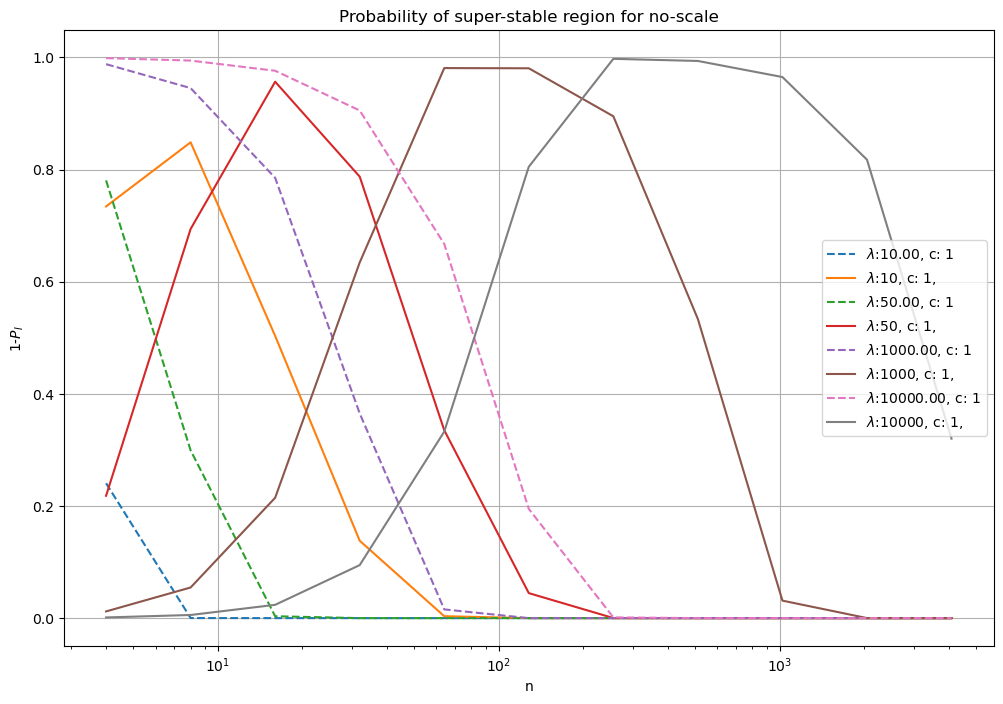

In [52]:
ns2 = np.array([4, 8, 16, 32, 64, 
               128, 256, 512, 1024, 
               2048, 4096])#, 8192])
c2 = 1#10
lambs2 = np.array([ c2*10, c2*50,  1000*c2, 10000*c2])

dists2 = np.array([[#create_Erlang_dist(np.sqrt(n-1)*lamb, n-1)
                     create_Erlang_dist(lamb, n-1)
                  for n in ns2]
                  for lamb in lambs2 ])
alphas2 = np.array([[alpha(c2, dist) 
                    for dist in dists2[i, :]]
                    for i in range(dists2.shape[0])
                  ])
alphas_n2 = np.array([[alpha**n
                      for alpha, n in zip(alphas2[i, :], ns2)]
                      for i in range(alphas2.shape[0])
                  ])

gamma = 0.0005
gammas_2 = np.array([[ psn3(c, lamb*np.sqrt(n), n) for n in ns2] for lamb in lambs2])

plt.figure(figsize=(12,8))
for k,lamb in enumerate(lambs2):
    plt.plot(ns2,
             alphas_n2[k, :], '--',
             label=r"$\lambda$:" f"{lamb:2.2f}, c:{c2:2.0f}")
    
#     plt.plot(ns,
#              (1 - gamma*(1-alphas2[k, :]))**ns2 - alphas2[k, :]**ns2, '-',
#              label=r"$\lambda$:" f"{lamb:2.0f}, c:{c2:2.0f}, " r"$\gamma:$" f"{gamma}")
    
    plt.plot(ns,
             (1 - gammas_2[k, :]*(1-alphas2[k, :]))**ns2 - alphas2[k, :]**ns2, '-',
             label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}, " )


plt.xlabel("n");plt.ylabel(r"1-$P_I$");plt.title(r"Probability of super-stable region for no-scale")    
plt.legend();plt.grid();plt.xscale('log');plt.show()


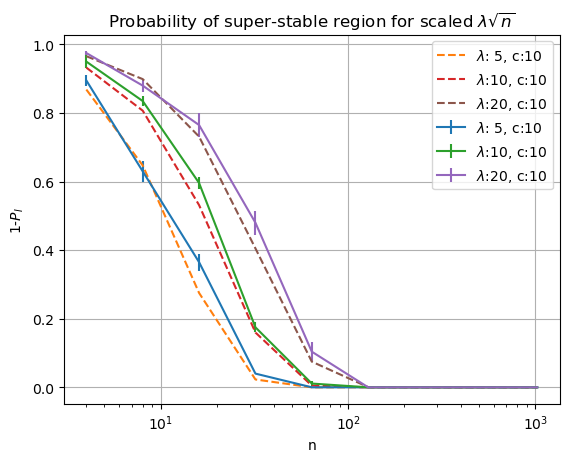

In [357]:
stats_super_stable = np.zeros((ns.shape[0], lambs.shape[0], repeats))
mean_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
std_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
for j,n in enumerate(ns):
    for k,lamb in enumerate(lambs):
        for t in range(repeats):
            index = j*lambs.shape[0]*repeats + k*repeats + t
            stats_super_stable[j, k, t ] =   res3[index][1]
            
mean_super_stable = np.mean(stats_super_stable, axis=2)
std_super_stable = np.std(stats_super_stable, axis=2)

for k,lamb in enumerate(lambs):
    plt.errorbar(ns, mean_super_stable[:, k],
                 yerr=std_super_stable[:, k],
                 label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}")
    plt.plot(ns,
             alphas_n[k, :], '--',
             label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}")

plt.xlabel("n");plt.ylabel(r"1-$P_I$");plt.title(r"Probability of super-stable region for scaled $\lambda \sqrt{n}$")    
plt.legend();plt.grid();plt.xscale('log');plt.show()



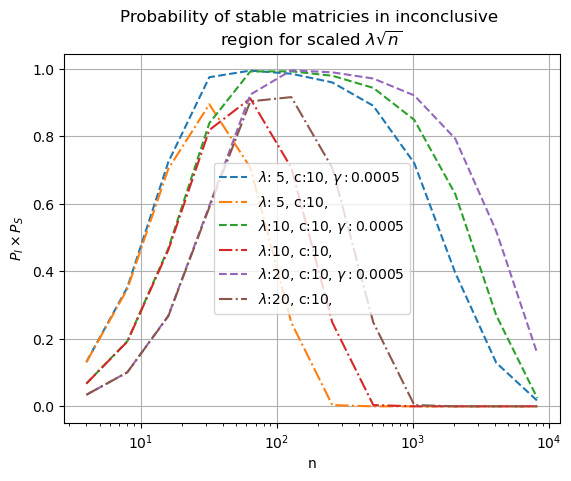

In [63]:
gamma = 0.0005
gammas_2 = np.array([[ psn3(c, lamb*np.sqrt(n), n) for n in ns] for lamb in lambs])
for k,lamb in enumerate(lambs): 
    plt.plot(ns,
             (1 - gamma*(1-alphas[k, :]))**ns - alphas[k, :]**ns, '--',
             label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}, " r"$\gamma:$" f"{gamma}")
    
    plt.plot(ns,
             (1 - gammas_2[k, :]*(1-alphas[k, :]))**ns - alphas[k, :]**ns, '-.',
             label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}, " )

plt.xlabel("n");plt.ylabel(r"$P_I \times P_S$");
plt.title("Probability of stable matricies in inconclusive \n" r"region for scaled $\lambda \sqrt{n}$")    
plt.legend();plt.grid();plt.xscale('log');plt.show()

